In [141]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [142]:
def plot_dynamic_spectra(dynamic_spectra, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        - dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        - title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    plt.xlabel("Time (ms)", size=14)
    plt.ylabel("Frequency (MHz)", size=14)
    plt.colorbar()
    plt.title(title, size=16)
    plt.show()

In [143]:
def rebin(arr, new_shape):
    """
    Rebins an array to a new shape by averaging over blocks of pixels.

    Parameters:
    - arr (numpy.ndarray): The input array to be rebinned.
    - new_shape (tuple): The desired shape of the rebinned array.

    Returns:
    - numpy.ndarray: The rebinned array with the specified new shape.
    """
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

## Load in the Data

In [144]:
# directories = [
#     "noiseless_1000_simple_narrow",
#     "noiseless_1000_simple_broad",
#     "noiseless_1000_simple_middle",
#     "noiseless_1000_simple_broad_narrow_time",
#     "noiseless_1000_scattered",
#     "noiseless_1000_complex",
#     "noiseless_1000_drifting",
# ]

# Define the directories containing the data for different classes
directories = [
    "1000_Constant_SNR_simple_narrow",
    "1000_Constant_SNR_simple_broad",
    "1000_Constant_SNR_simulated_scattered",
    "1000_Constant_SNR_complex",
    "1000_Constant_SNR_drifting",
]

# Initialize lists to store data and corresponding labels
data = []
labels = []

# Iterate over each class directory
for class_idx, directory in enumerate(directories):
    # Construct the full path to the data directory
    data_dir = f"data/{directory}"
    data_per_directory = []

    # Iterate over each file in the directory
    for filename in os.listdir(data_dir):
        if filename.endswith(".npy"):
            # Load the dynamic spectra with pulse from the file
            dynamic_spectra_w_pulse = np.load(os.path.join(data_dir, filename))
            
            # Rebin the spectrum to a smaller size
            rebinned_spectrum = rebin(dynamic_spectra_w_pulse, (int(1024/4), int(512/4)))
            
            # Ensure no zero values in the rebinned spectrum to avoid issues during processing
            if np.any(rebinned_spectrum == 0.0):
                rebinned_spectrum[rebinned_spectrum == 0] = 0.0001
            
            # Append the rebinned spectrum to the list of data for this class
            data_per_directory.append(rebinned_spectrum)
            
            # Append the class index as the label for this data point
            labels.append(class_idx)

    # Limit the number of data points per class
    data_per_directory = np.array(data_per_directory)[:1000]
    
    # Append the data for this class to the overall data list
    data.append(data_per_directory)

# Concatenate the data and labels for all classes
data = np.concatenate(data, axis=0)
labels = np.array(labels)

# Split the data into training and testing sets while maintaining class balance
test_size = 0.2
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=test_size, shuffle=True, random_state=42)


## Standard Scale the data

In [145]:
# Create Standard Scaler
scaler = StandardScaler()
scaler.fit(data_train.reshape(-1, int(1024/4) * int(512/4)))

# Transform data
data_train_scaled = scaler.transform(data_train.reshape(-1, int(1024/4) * int(512/4)))
data_test_scaled = scaler.transform(data_test.reshape(-1, int(1024/4) * int(512/4)))

## In case we want Unscaled data

In [146]:
data_train_unscaled = data_train.reshape(-1, int(1024/4) * int(512/4))
data_test_unscaled = data_test.reshape(-1, int(1024/4) * int(512/4))

## What does a Scaled FRB look like?

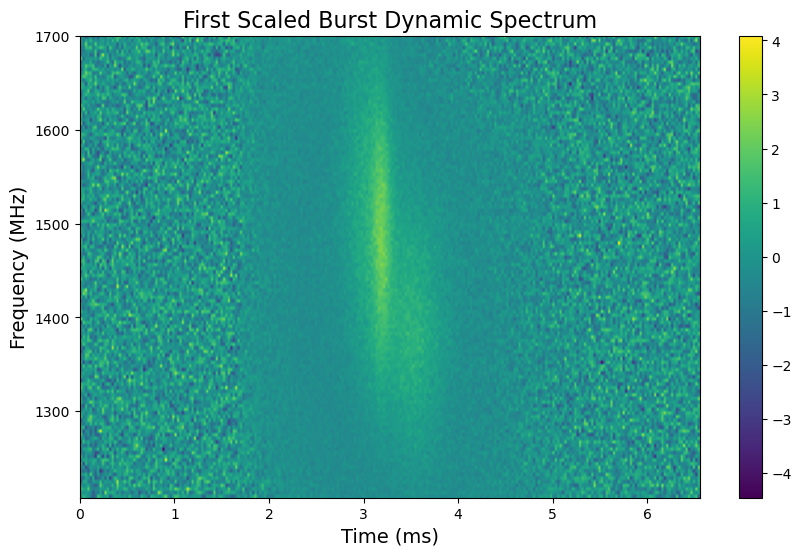

In [147]:
# Extract the first scaled burst
scaled_burst = data_train_scaled[0]

# Reshape the scaled burst to its original shape
scaled_burst_reshaped = scaled_burst.reshape(int(1024/4), int(512/4))

# Plot the dynamic spectrum of the first scaled burst
plot_dynamic_spectra(scaled_burst_reshaped, title="First Scaled Burst Dynamic Spectrum")

## What does the Unscaled burst look like?

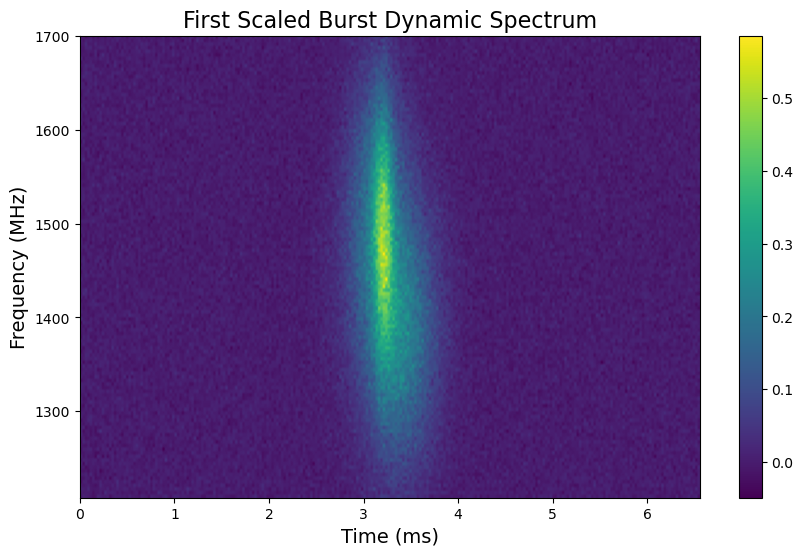

In [148]:
# Extract the first scaled burst
unscaled_burst = data_train_unscaled[0]

# Reshape the scaled burst to its original shape
unscaled_burst_reshaped = unscaled_burst.reshape(int(1024/4), int(512/4))

# Plot the dynamic spectrum of the first scaled burst
plot_dynamic_spectra(unscaled_burst_reshaped, title="First Scaled Burst Dynamic Spectrum")

## Visualize PCA latent space

In [149]:
# Apply PCA to the combined data
n_components = 8  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
fit = pca.fit(data_train_unscaled)
transformed_fit = pca.fit_transform(data_train_unscaled)

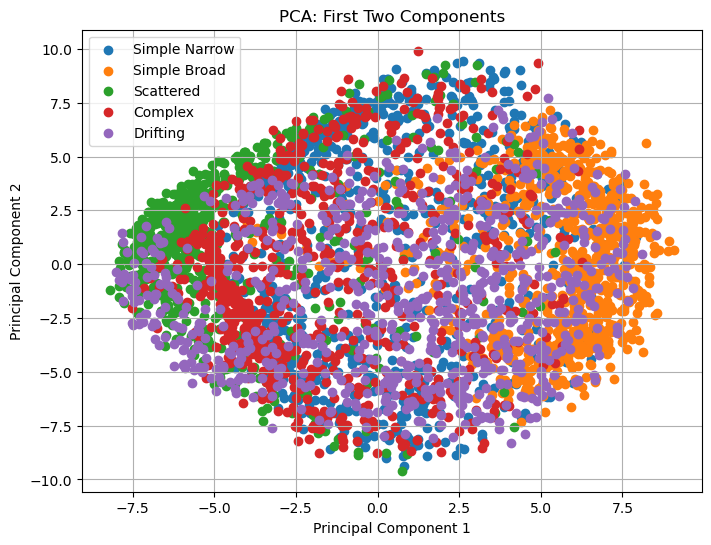

In [151]:
# Plot the first two principal components colored by burst category
plt.figure(figsize=(8, 6))
labels = ["Simple Narrow", "Simple Broad", "Scattered", "Complex", "Drifting"]

for i in range(len(labels)):
    indices = np.where(labels_train == i)
    plt.scatter(transformed_fit[indices, 0], transformed_fit[indices, 1], label=labels[i])

plt.title('PCA: First Two Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

## Look at Neighbors to see how class information is preserved

In [135]:
from sklearn.neighbors import KDTree
import numpy as np

## Metric using K-NN and computing ratio of similar classes

def get_sim_class(representations, labels, K=20):
    ## Return
    ##     - mean of the class-similarity ratio, 
    ##     - array of individual ratios (same number of examples as in representations)
    
    # Build a KDTree using the representations
    kdt = KDTree(representations, leaf_size=10, metric='euclidean')
    ratios = []
    
    ## For each example, get the K nearest neighbours in the representations set
    ## And compute the ratios of the neighbours that have the same labels (class) as the current point
    for i in range(len(representations)):
        ## We could find a smart way to weight by distance for a different type of metric, 
        ## e.g. computing vote and checking accuracy score
        distances, neighbors = kdt.query(representations[i].reshape(1,-1), k=K+1, return_distance=True)
        
        ## KDTree returns the indices of the K nearest neighbors but also include the current example if it's
        ## in the "training set"
        neighbors = neighbors[0][1:]
        ratio_ = np.sum(labels[neighbors]==labels[i])/K
        ratios.append(ratio_)
    return np.mean(np.array(ratios)), np.array(ratios)

# Compute
mean_ratio, individual_ratios = get_sim_class(transformed_fit, labels_train)
print("Mean of the class-similarity ratio:", mean_ratio)
print("Array of individual ratios:", individual_ratios)

Mean of the class-similarity ratio: 0.7997249999999999
Array of individual ratios: [0.55 0.75 0.85 ... 0.2  1.   1.  ]


## Mean squared error histogram

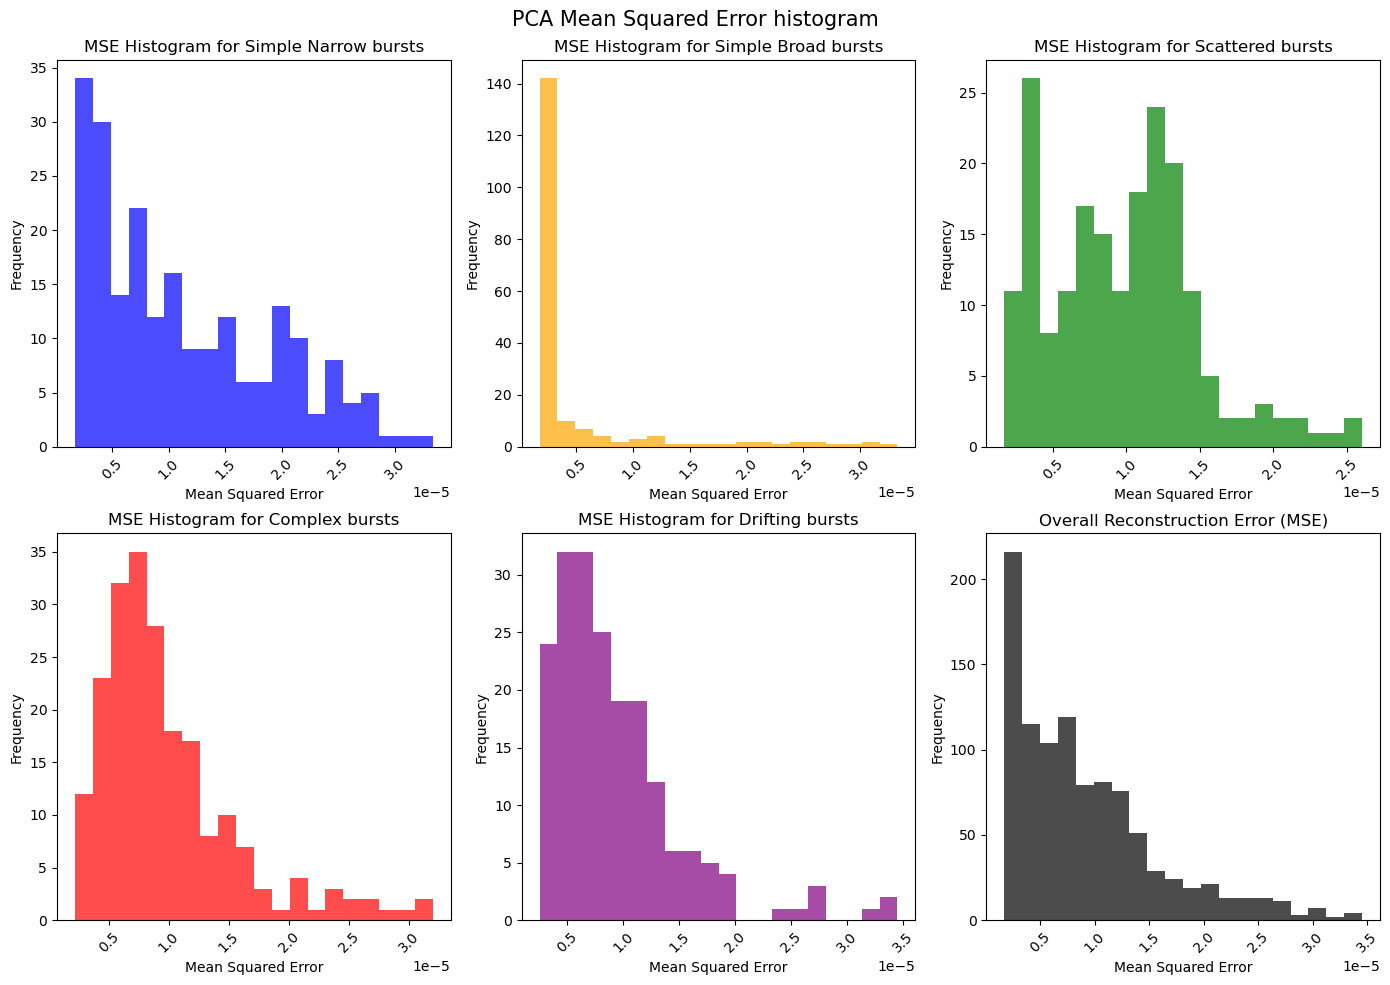

In [136]:
# Calculate the mean square error for each burst and each class
mse_all = []

# Calculate overall mean square error
for original_burst in data_test_unscaled:
    original_burst_reshaped = original_burst.reshape(-1, int(1024/4) * int(512/4))
    reconstructed_burst = pca.inverse_transform(pca.transform(original_burst_reshaped))
    original_burst_comparison = scaler.inverse_transform(original_burst_reshaped)
    reconstructed_burst_comparison = scaler.inverse_transform(reconstructed_burst)
    mse = mean_squared_error(original_burst_comparison, reconstructed_burst_comparison)
    mse_all.append(mse)

# Define labels for each directory
labels = [
    "Simple Narrow",
    "Simple Broad",
    "Scattered",
    "Complex",
    "Drifting"
]

# Set the figure size
fig, axes = plt.subplots(2, 3 ,figsize=(14, 10)) # Can also share x-axes
axes = np.hstack(axes)
# axes[0].set_xlim(0, 0.007)

# Define colors for each label
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Create subplots for each directory
for i, label in enumerate(labels):
    num_samples = np.sum(labels_test == i)  # Count the number of samples for this label

    # Extract the MSE values for the current directory
    mse_directory = np.array(mse_all)[np.array(labels_test) == i]

    # Create subplots with colored histograms
    axes[i].hist(mse_directory, bins=20, color=colors[i], alpha=0.7)
    axes[i].set_title(f'MSE Histogram for {label} bursts')
    axes[i].set_xlabel('Mean Squared Error')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate the x-axis tick labels by 45 degrees

# Calculate overall mean square error for autoencoder reconstructions
mse_all = np.array(mse_all)
axes[-1].hist(mse_all, bins=20, color='black', alpha=0.7)
axes[-1].set_title('Overall Reconstruction Error (MSE)')
axes[-1].set_xlabel('Mean Squared Error')
axes[-1].set_ylabel('Frequency')
axes[-1].tick_params(axis='x', rotation=45)  # Rotate the x-axis tick labels by 45 degrees

# Adjust layout for better visualization
plt.tight_layout()

# Increase top spacing between subplots and the main title
plt.subplots_adjust(top=.93)

# Add the main title
plt.suptitle('PCA Mean Squared Error histogram', fontsize=15)

# Show the plot
plt.show()

## Look at Reconstruction Error as a function of PCA Components

In [137]:
# Initialize a list to store MSE values for different latent space sizes
mse_list = []

# Iterate over different numbers of components
for i in range(25):
    # Apply PCA to the combined data
    n_components = i + 1  # Increment by 1 to start from 1 component
    pca = PCA(n_components=n_components)
    fit = pca.fit(data_train_unscaled)

    # Calculate the mean square error for each burst and each class
    mse_all = []

    # Calculate overall mean square error
    for original_burst in data_test_unscaled:
        original_burst_reshaped = original_burst.reshape(-1, int(1024/4) * int(512/4))
        reconstructed_burst = pca.inverse_transform(pca.transform(original_burst_reshaped))
        original_burst_comparison = scaler.inverse_transform(original_burst_reshaped)
        reconstructed_burst_comparison = scaler.inverse_transform(reconstructed_burst)
        mse = mean_squared_error(original_burst_comparison, reconstructed_burst_comparison)
        mse_all.append(mse)


    # Append MSE values for the current latent space size to the list
    mse_list.append(mse_all)

# Convert the MSE list to a NumPy array for saving
mse_array = np.array(mse_list)

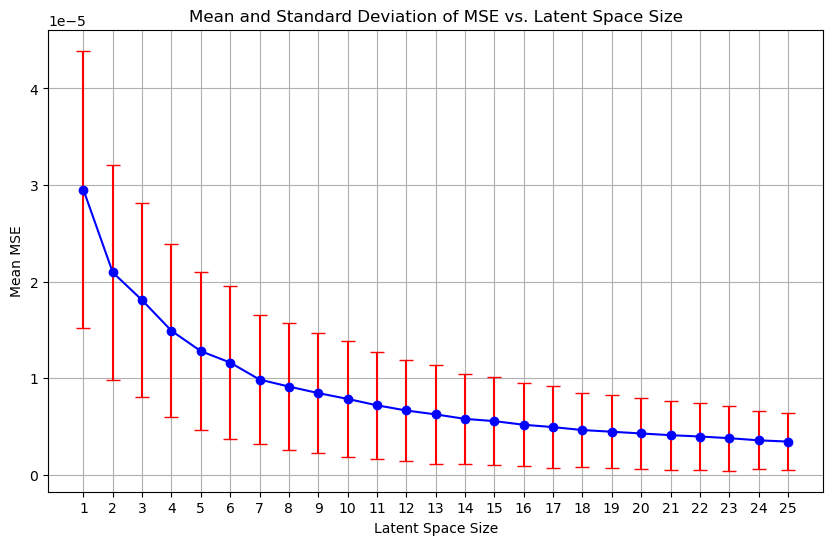

In [138]:
# Compute the mean and standard deviation
mse_mean = np.mean(mse_array, axis=1)
mse_std = np.std(mse_array, axis=1)

# Define latent space sizes
latent_space_sizes = np.arange(1, mse_array.shape[0] + 1)

# Plot mean and standard deviation against latent space size
plt.figure(figsize=(10, 6))
plt.errorbar(latent_space_sizes, mse_mean, yerr=mse_std, fmt='-o', color='b', ecolor='r', capsize=5)
plt.title('Mean and Standard Deviation of MSE vs. Latent Space Size')
plt.xlabel('Latent Space Size')
plt.ylabel('Mean MSE')
plt.xticks(latent_space_sizes)
plt.grid(True)
plt.show()

## Look at Reconstruction Error as a function of PCA components including Different Classes

In [139]:
# Define the number of components for PCA
n_components = 25  # Number of components for PCA

# Initialize lists to store MSE values for each class and combined
mse_per_class_list = []
mse_combined_list = []

# Iterate over each component
for i in range(n_components):
    mse_per_class_combined = []  # Store MSE for each class combined
    mse_combined = []   # Store MSE for all classes combined
    
    # Apply PCA to the full training data
    pca_full = PCA(n_components=i + 1)  # Increment by 1 to start from 1 component
    pca_full.fit(data_train_unscaled)
    
    # Evaluate on the test data
    # Calculate the mean square error for all classes combined
    reconstructed_test = pca_full.inverse_transform(pca_full.transform(data_test_unscaled))
    mse_comb = mean_squared_error(data_test_unscaled, reconstructed_test)
    mse_combined.append(mse_comb)
    
    # Iterate over each class
    for class_idx, label in enumerate(labels):
        # Apply PCA to the data of the current class
        combined_data_class = data_test_unscaled[labels_test == class_idx]
        
        # Calculate the mean square error for the current class
        reconstructed_class = pca_full.inverse_transform(pca_full.transform(combined_data_class))
        mse_class = mean_squared_error(combined_data_class, reconstructed_class)
        mse_per_class_combined.append(mse_class)
    
    # Append MSE values for all classes combined and per class to the lists
    mse_per_class_list.append(mse_per_class_combined)
    mse_combined_list.append(mse_combined)

# Convert the MSE lists to NumPy arrays for saving
mse_per_class_array = np.array(mse_per_class_list)
mse_combined_array = np.array(mse_combined_list)


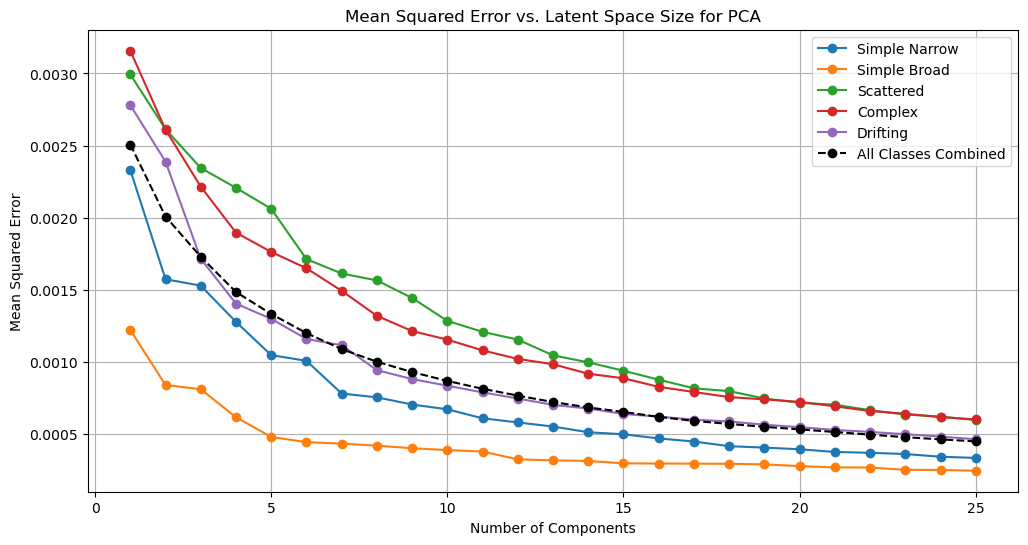

In [140]:
# Plot MSE for each class separately
plt.figure(figsize=(12, 6))
for class_idx, label in enumerate(labels):
    mse_per_class = mse_per_class_array[:, class_idx]
    plt.plot(np.arange(1, n_components + 1), mse_per_class, marker='o', linestyle='-', label=label)

# Plot MSE for all classes combined
mse_combined = mse_combined_array[:, 0]  # MSE for all classes combined
plt.plot(np.arange(1, n_components + 1), mse_combined, marker='o', linestyle='--', color="black", label="All Classes Combined")
plt.title('Mean Squared Error vs. Latent Space Size for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()
